# Preamble

In [27]:
# dependencies
import numpy as np
import os
import re
import sys
import glob
import collections

from scipy.interpolate import interp1d
from scipy import optimize

import pandas as pd
from astropy.io import fits, ascii
import photoz_metrics

from astropy.table import Table, join


import matplotlib
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns


# plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')

# sns.set_style('darkgrid')

plt.rc('pdf',fonttype=42)
sns.mpl.rc('figure', figsize = (14, 8))
sns.set_context('notebook', font_scale=2.5, rc={'lines.linewidth': 2.5})


# options
# %matplotlib inline
# import matplotlib.pyplot as plt
# from matplotlib import rc

# rc('figure', figsize = (12, 8))
# rc('font',**{'size': 30, 'family':'serif', 'serif':['Palatino']})
# rc('text', usetex=True)

STILTS = 'java -Xmx2048M -jar /Users/coupon/local/bin/stilts.jar'
DATADIR = os.environ['HOME']+'/data/euclid/varTrans'
CURRENTDIR = '../'


# add ./python to python path
path_python = '../python'
if not path_python in sys.path:
    sys.path.insert(0, '../python')

import var_trans_utils as vtu

from importlib import reload

In [11]:
sys.path

['../python',
 '',
 '/Users/coupon/local/source/GitHub/euclid_var_trans/scripts',
 '/Users/coupon/local/lib/python',
 '/Users/coupon/local/source/NNPZ',
 '/Users/coupon/local/source/GitHub/halomodel',
 '/Users/coupon/local/source/GitHub/euclid_phz_testing',
 '/Users/coupon/anaconda3/lib/python37.zip',
 '/Users/coupon/anaconda3/lib/python3.7',
 '/Users/coupon/anaconda3/lib/python3.7/lib-dynload',
 '/Users/coupon/anaconda3/lib/python3.7/site-packages',
 '/Users/coupon/anaconda3/lib/python3.7/site-packages/aeosa',
 '/Users/coupon/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/Users/coupon/.ipython']

# Variable transmissions

## Measured variations on current filters

### OmegaCam at VST

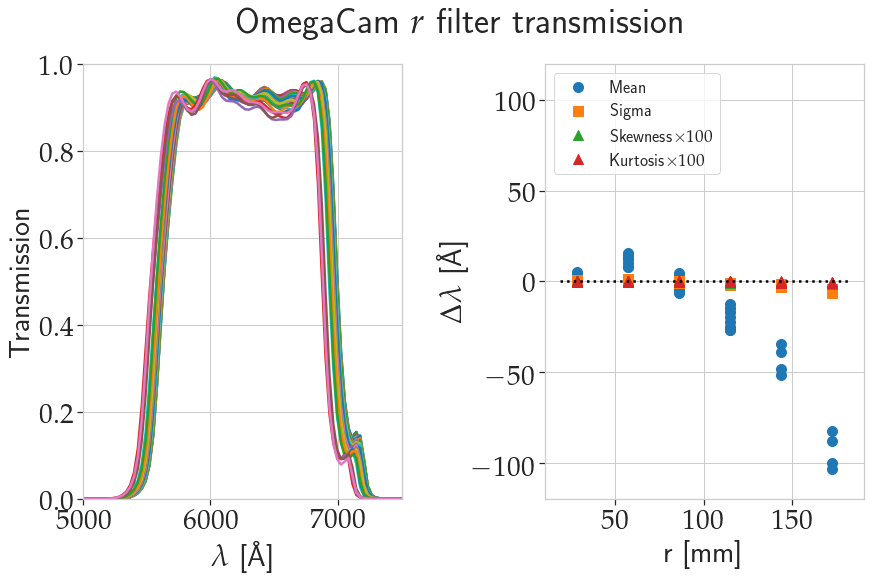

In [29]:
reload(vtu)

# read data
filter_name = 'r'
filter_var_df = pd.read_csv(
    CURRENTDIR+'/doc/OmegaCam/'+filter_name+'_orig_transmission_data', 
    header=None, sep='\s+', comment='#', 
    names=['lambda']+[str(i) for i in range(2,51)])

# read positions (except the last two positions)
with open(
    CURRENTDIR+'/doc/OmegaCam/r_orig_transmission_data', 'r') as f:
    lines = f.readlines()
    filter_pos = pd.DataFrame({
        'x' : np.array(lines[4].split()[2:-2], dtype=np.float),
        'y' : np.array(lines[5].split()[2:-2], dtype=np.float),
        'r' : np.array(lines[8].split()[2:-2], dtype=np.float)})
    
# convert lambda to Angstroms
filter_var_df['lambda'] *= 10.0

# remove last two curves (not used)
filter_var_df.drop('49', axis=1, inplace=True)
filter_var_df.drop('50', axis=1, inplace=True)

# plot transmission
f, (ax1, ax2) = plt.subplots(1,2)
t = 'OmegaCam ${}$ filter transmission'.format(filter_name)

ax_trans = vtu.plot_trans(
    filter_var_df, '', (5000, 7500), ax=ax1)

center = (filter_pos['r'] < 7).values
off_center = (filter_pos['r'] > 7).values
col_center = [str(i) for i in np.array(range(2,49))[center]]
col_off_center = [str(i) for i in np.array(range(2,49))[off_center]]

select = (5000 < filter_var_df['lambda']) & (filter_var_df['lambda'] < 7500)

ax_stats = vtu.plot_stats(
    filter_var_df[col_center][select], 
    filter_var_df[col_off_center][select],
    filter_pos['r'][off_center],
    filter_var_df['lambda'][select], '', 
    ylim=(-120.,+120.), plot_legend=True,
    legend_size = 'xx-small',
    file_out='../results/OmegaCam.csv', ax=ax2)

f.subplots_adjust(wspace=0.45)

f.suptitle(t)
# f.set_tight_layout(True)
f.savefig('../plots/OmegaCam.pdf')

### JAST at Javalembre

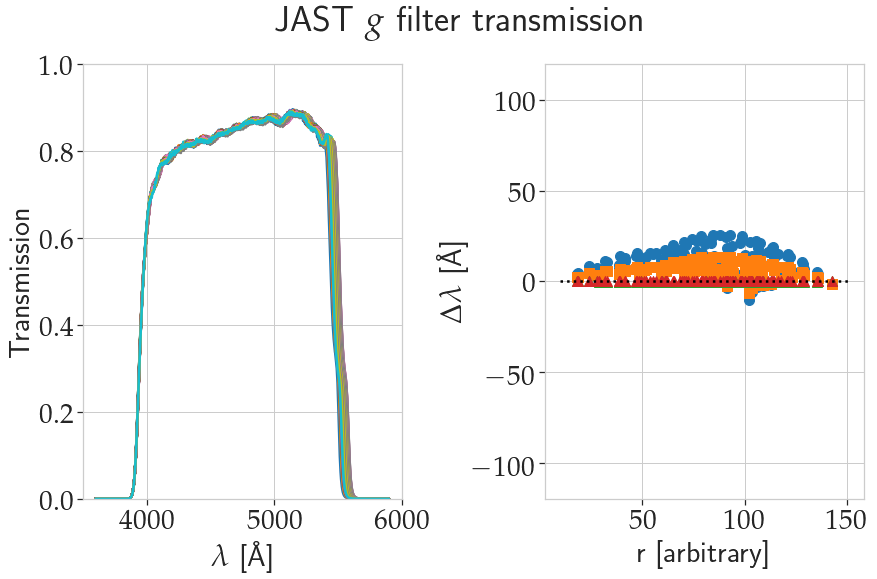

In [30]:
## read data
filter_name = 'g'
filter_var_df = pd.read_csv(
    CURRENTDIR+'/doc/JAST/'+filter_name+'SDSS_2D_JAST_OAJ.txt', 
    header=None, sep='\s+', comment='#', 
    names=['lambda', 'ref1']
    +[str(i) for i in range(3,103)]+['ref2'])

# convert lambda to Angstroms
filter_var_df['lambda'] *= 10.0

# convert transmission from 100 to 1
for i in range(3,103):
    filter_var_df[str(i)] /= 100.0

# remove last two curves not used in science
filter_var_df.drop('ref1', axis=1, inplace=True)
filter_var_df.drop('ref2', axis=1, inplace=True)

filter_pos = pd.read_csv(
    CURRENTDIR+'/doc/JAST/'+filter_name+'SDSS_2D_Positions.tab', 
    header=None, sep='\s+', comment='#', 
    names=['id', 'x', 'y'])

# add radius
filter_pos['r'] = pd.Series(
    np.sqrt(filter_pos['x']**2+filter_pos['y']**2))

# plot transmission
f, (ax1, ax2) = plt.subplots(1,2)
t = 'JAST ${}$ filter transmission'.format(filter_name)

ax_trans = vtu.plot_trans(
    filter_var_df,
    '', (3500, 6000), ax=ax1)

center = (filter_pos['r'] < 10).values
off_center = (filter_pos['r'] > 10).values
col_center = [str(i) for i in np.array(range(3,103))[center]]
col_off_center = [str(i) for i in np.array(range(3,103))[off_center]]

ax_stats = vtu.plot_stats(
    filter_var_df[col_center], 
    filter_var_df[col_off_center],
    filter_pos['r'][off_center],
    filter_var_df['lambda'], '',
    xlabel='r [arbitrary]', ylim=(-120.,+120.), 
    file_out='../results/JAST.csv', ax=ax2)

f.subplots_adjust(wspace=0.45)

f.suptitle(t)
# f.set_tight_layout(True)
f.savefig('../plots/JAST.pdf')

### MegaCam at CFHT

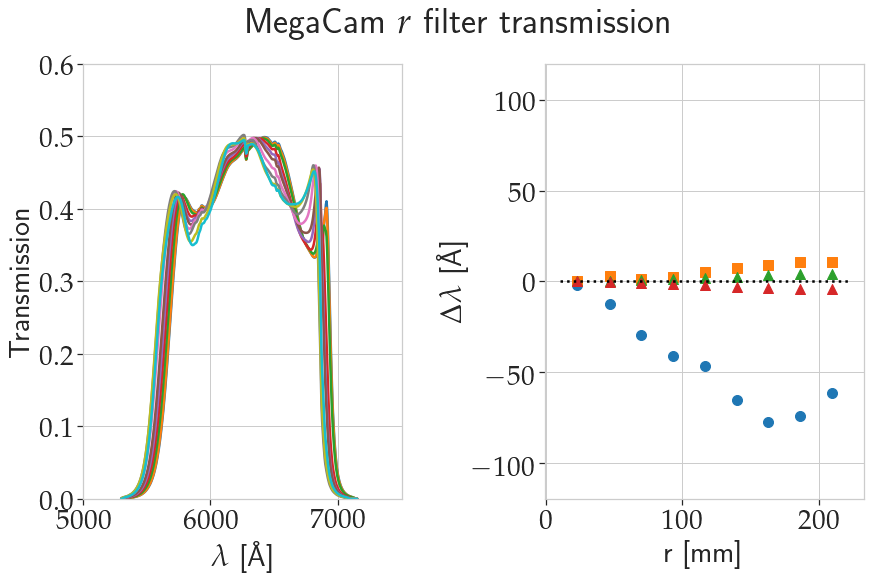

In [31]:
# read data
filter_name = 'r'
filter_var_df = pd.read_csv(
    CURRENTDIR+'/doc/MegaCam/Betoule2013_'+filter_name+'.txt', 
    header=None, sep='|', comment='#', 
    names=['lambda']
    +[str(i) for i in range(1,11)] )

filter_pos = pd.DataFrame({
        'r': np.array([0.0, 23.0, 47.0, 
        70.0, 93.0, 117.0, 140.0, 163.0, 
        186.0, 210.0])})

center = (filter_pos['r'] < 10.).values
off_center = (filter_pos['r'] > 10.0).values
col_center = [str(i) for i in np.array(range(1,11))[center]]
col_off_center = [str(i) for i in np.array(range(1,11))[off_center]]

# plot transmission
f, (ax1, ax2) = plt.subplots(1,2)
t = 'MegaCam ${}$ filter transmission'.format(filter_name)

ax_trans = vtu.plot_trans(
    filter_var_df,
    '', 
    (5000, 7500), ylim=(0.0,0.6), ax=ax1)

ax_stats = vtu.plot_stats(
    filter_var_df[col_center], 
    filter_var_df[col_off_center],
    filter_pos['r'][off_center],
    filter_var_df['lambda'], '',
    ylim=(-120.,+120.), file_out='../results/MegaCam.csv', ax=ax2)


f.subplots_adjust(wspace=0.45)

f.suptitle(t)
# f.set_tight_layout(True)
f.savefig('../plots/megacam.pdf')

### The Sloan camera



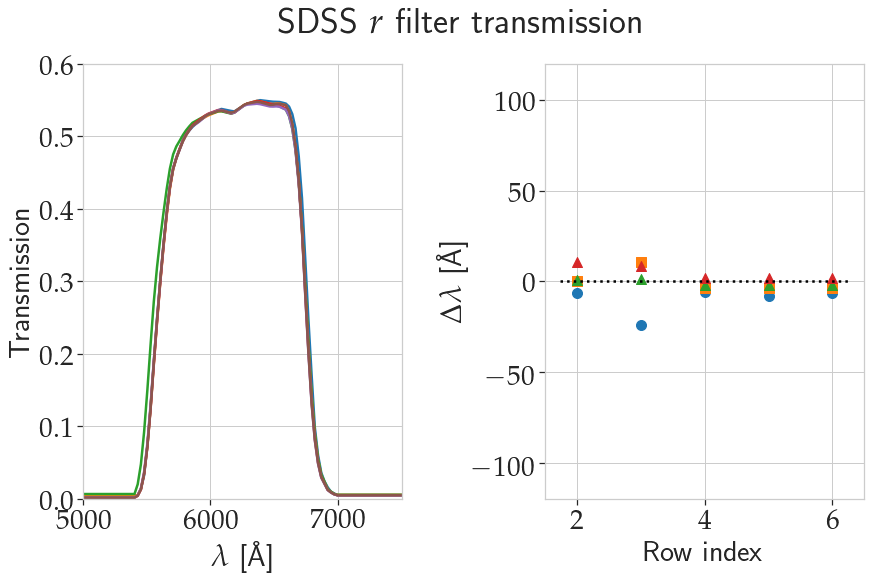

In [32]:
## read data
filter_name = 'r'
df = { 'lambda': np.linspace(5000.0, 7500., 100) }

for i in range(1,7):
    t = ascii.read(CURRENTDIR+'/doc/SDSS/'+filter_name+str(i)+'.dat')
    df['trans'+str(i)] = np.interp(df['lambda'], t['col1'], t['col2'])

filter_var_df = pd.DataFrame(df)

col_center = ['trans1']
col_off_center = ['trans'+str(i) for i in np.array(range(2,7))]

# plot transmission
f, (ax1, ax2) = plt.subplots(1,2)
t = 'SDSS ${}$ filter transmission'.format(filter_name)

ax_trans = vtu.plot_trans(
    filter_var_df,
    '', 
    (df['lambda'][0], df['lambda'][-1]), ylim=(0.0,0.6), ax=ax1)

ax_stats = vtu.plot_stats(
    filter_var_df[col_center], 
    filter_var_df[col_off_center],
    [float(i) for i in range(2,7)],
    filter_var_df['lambda'], '',
    ylim=(-120.,+120.),
    xlabel='Row index', file_out='../results/SDSS.csv', ax=ax2)


f.subplots_adjust(wspace=0.45)

f.suptitle(t)
# f.set_tight_layout(True)
f.savefig('../plots/sdss.pdf')

### DECam at the Blanco telescope

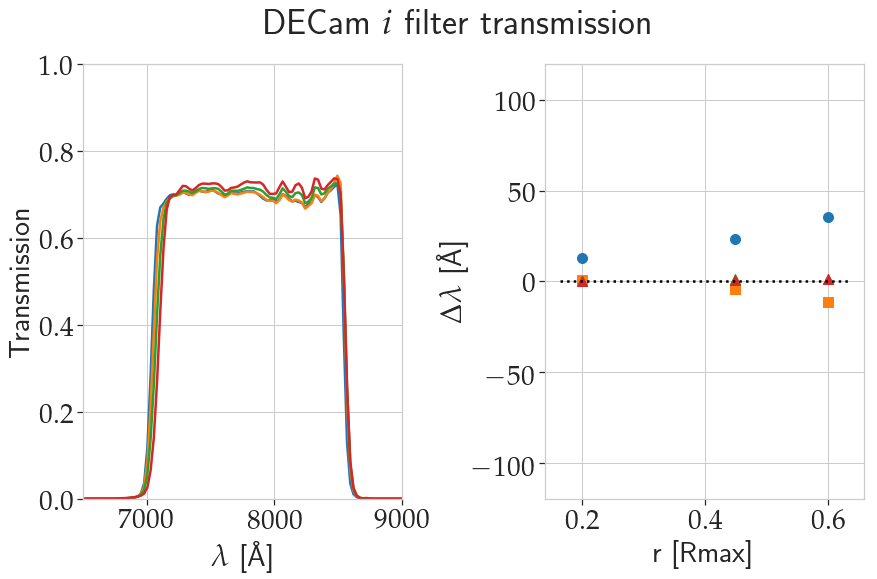

In [33]:
# read data
# In all files, the columns are wavelength (nm),  
# average (entire focal plane),  region1,  region2,  
# region3,  region4 (as defined in the paper).  
# Please ignore the last column. 

# lbda_min = 5000.0
# lbda_max = 9000.0
# filter_name = 'r'

lbda_min = 6500.0
lbda_max = 9000.0
filter_name = 'i'

df = { 'lambda': np.linspace(lbda_min, lbda_max, 100) }

for i in range(1,5):
    t = ascii.read(CURRENTDIR+'/doc/DECam/Li2016/'+filter_name+'.dat')
    df['trans'+str(i)] = np.interp(df['lambda'], t['col1']*10.0, t['col'+str(i+2)]/np.mean(t['col'+str(i+2)])/2.0)
    
filter_pos = pd.DataFrame({
        'r': np.array( [0.0, 0.2, 0.45, 0.6])})
    
filter_var_df = pd.DataFrame(df)

center = (filter_pos['r'] < 0.1).values
off_center = (filter_pos['r'] > 0.1).values
col_center = ['trans1']
col_off_center = ['trans'+str(i) for i in np.array(range(2,5))]

# plot transmission
f, (ax1, ax2) = plt.subplots(1,2)
t = 'DECam ${}$ filter transmission'.format(filter_name)

ax_trans = vtu.plot_trans(
    filter_var_df,
    '', 
    (lbda_min, lbda_max), ylim=(0.0,1.0), ax=ax1)

ax_stats = vtu.plot_stats(
    filter_var_df[col_center], 
    filter_var_df[col_off_center],
    filter_pos['r'][off_center],
    filter_var_df['lambda'], '',
    ylim=(-120.,+120.), xlabel='r [Rmax]', 
    file_out='../results/DECam.csv', ax=ax2)


f.subplots_adjust(wspace=0.45)

f.suptitle(t)
# f.set_tight_layout(True)
f.savefig('../plots/decam.pdf')

### Hyper Suprime Cam at Subaru

Asked Suzuki-san for the filter curves a number of times with no answer. Used the quoted shift of 7 nm in Miyazaki et al. (2017) instead.


## Modeling the variations


In [38]:
reload(vtu)

# defintion of a r-band top-hat filter
filter_var_df = pd.DataFrame(vtu.create_r_top_hat_trans('r'))

# number of different variations
VAR_N = 10

# define range of variations
VAR_VALUES = collections.OrderedDict()
VAR_VALUES['shift'] = np.linspace(-100.0, +100.0, VAR_N)
VAR_VALUES['stretch'] = np.linspace(-3.0e-2, +3.0e-2, VAR_N)
VAR_VALUES['tilt'] = np.linspace(-0.15, +0.15, VAR_N)
VAR_VALUES['softening'] = np.linspace(0.0, 0.8, VAR_N)
VAR_VALUES['scaling'] = np.linspace(-0.05, +0.05, VAR_N)

VAR_UNITS = collections.OrderedDict()
VAR_UNITS['shift'] =  '\AA{{}}'
VAR_UNITS['stretch'] = '\%'
VAR_UNITS['tilt'] = '\%'
VAR_UNITS['softening'] = '\sigma'
VAR_UNITS['scaling'] = '\%'

for i in range(VAR_N):
    for t in VAR_VALUES:
        if t == 'scaling':
            continue
        filter_var_df[t+str(i)] = \
            pd.Series(getattr(vtu, t+'_trans')(
                filter_var_df['lambda'], 
                filter_var_df['trans'], 
                VAR_VALUES[t][i]))

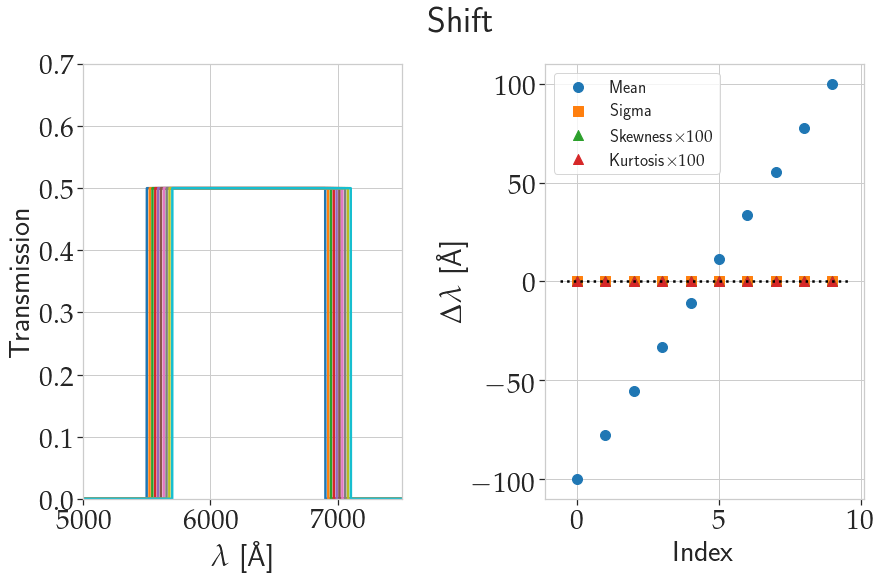

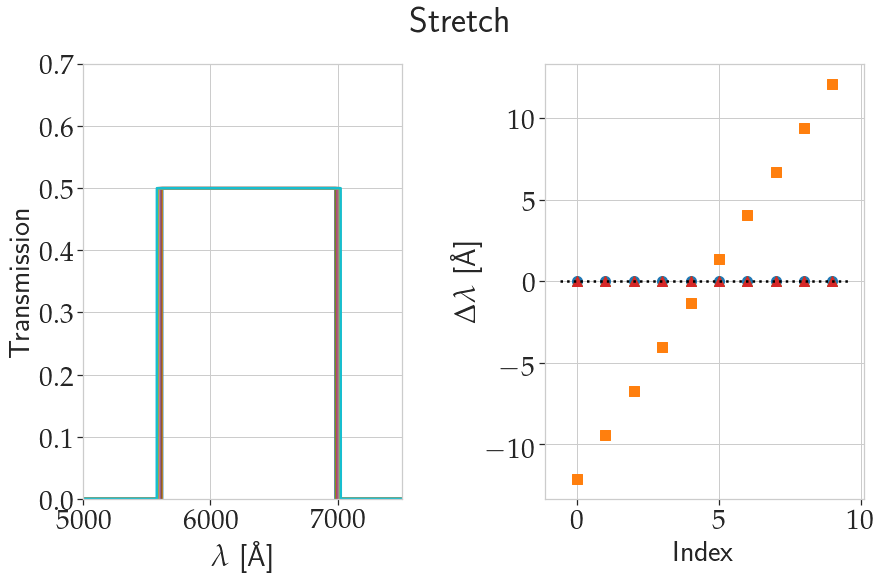

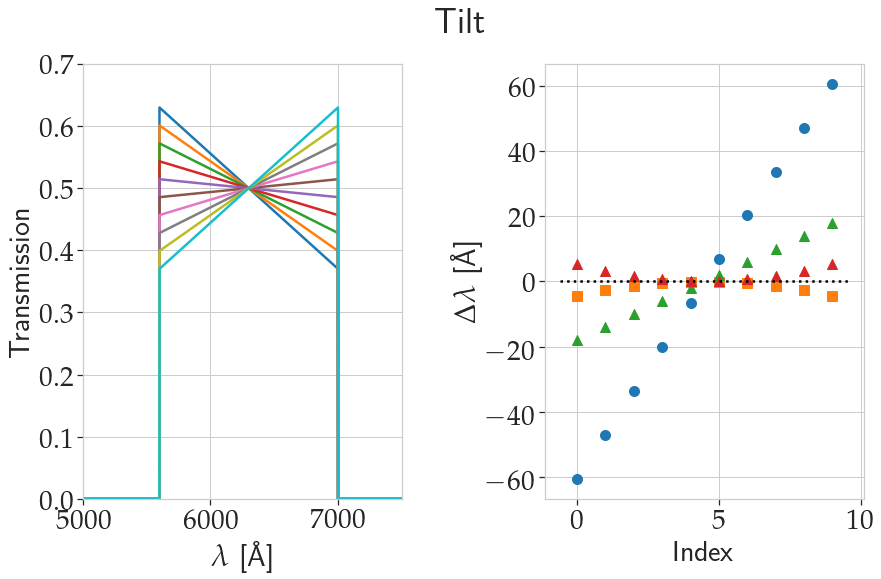

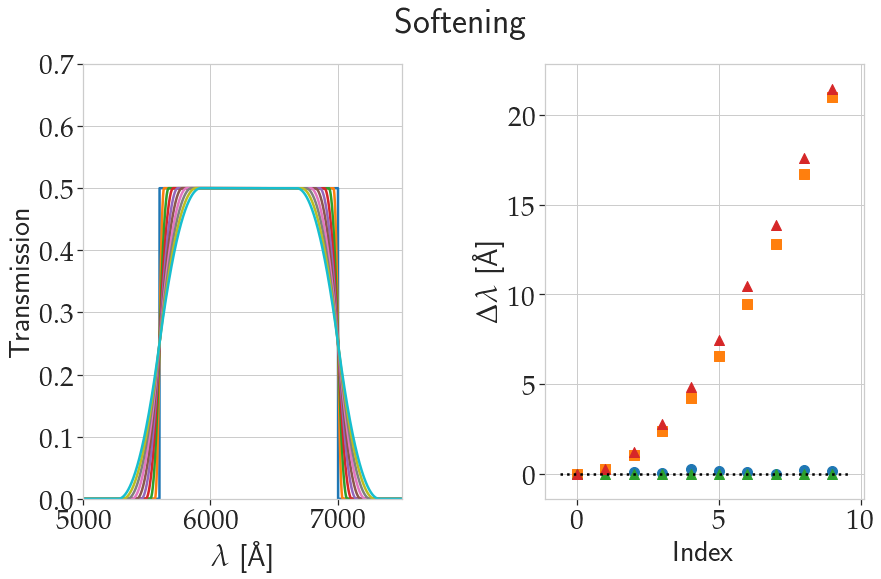

In [40]:
# plot transmission and stats
for t in VAR_VALUES:
    
    plot_legend = False
    if t == 'shift':
        plot_legend = True

    
    # treat scaling differently as 
    # the shape is SED independent
    if t == 'scaling':
        
        stats_dict = collections.OrderedDict({})
        stats_dict['mean'] = [0.0]*VAR_N
        stats_dict['sigma'] = [0.0]*VAR_N
        stats_dict['skewness'] = [0.0]*VAR_N
        stats_dict['kurtosis'] = [0.0]*VAR_N
        df = pd.DataFrame(stats_dict)
        df.to_csv(
            '../results/trans_stats_{}.csv'.format(t), 
            index=False)
    else:
        f, (ax1, ax2) = plt.subplots(1,2)
        ax_trans = vtu.plot_trans(
            filter_var_df.filter(regex='lambda|'+t+'*'),
            '', (5000, 7500), ylim=(0.0,0.7), ax=ax1)

        col_center = ['trans']
        col_off_center = [t+str(i) for i in range(10)]

        ax_stats = vtu.plot_stats(
            filter_var_df[col_center],
            filter_var_df[col_off_center],
            range(10),
            filter_var_df['lambda'], '',
            xlabel='Index', ax=ax2, 
            ylim=None, 
            legend_size = 'xx-small',
            file_out='../results/trans_stats_{}.csv'.format(t), 
            plot_legend=plot_legend)
        f.subplots_adjust(wspace=0.45)

        f.suptitle(t.title())
        # f.set_tight_layout(True)
        f.savefig('../plots/r_'+t+'.pdf')
        